In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from scipy.integrate import simps
import warnings
warnings.filterwarnings("ignore")

# Read data

In [2]:
# read bacterial relative abundance
df_16S_relab = pd.read_csv('../../../our_data/16S_relative_abundance_species.csv', index_col=0)

# read qPCR
df_qpcr = pd.read_csv('../../../our_data/qPCR.csv', index_col=0)

# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_16S_relab = df_16S_relab.loc[df_meta.index]
df_qpcr = df_qpcr.loc[df_meta.index]
df_meta = pd.merge(df_meta, df_16S_relab, left_index=True, right_index=True)
df_meta = pd.merge(df_meta, df_qpcr, left_index=True, right_index=True)
df_meta.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,A2,ASF356,Acetatifactor,Acetatifactor-muris,Acidovorax,...,[Eubacterium]-xylanophilum-group,[Ruminococcus]-gnavus-group,[Ruminococcus]-torques-group,bacterium-enrichment-culture-clone-M153,gut-metagenome,human-gut-metagenome,marine-metagenome,metagenome,mouse-gut-metagenome,Value
SampleID,,,,,,,,,,,,,,,,,,,,,
sample141,BI1,Beijing,0,Inulin,A,0.000000,0.000795,0.001339,0.0,0.0,...,0.000679,0.0,0.0,0.0,0.002735,0.0,0.000000,0.0,0.002832,7.332081e+07
sample142,BI2,Beijing,0,Inulin,B,0.001752,0.000554,0.000734,0.0,0.0,...,0.000412,0.0,0.0,0.0,0.001056,0.0,0.000039,0.0,0.002371,4.562151e+07
sample143,BI3,Beijing,0,Inulin,D,0.000000,0.000849,0.000394,0.0,0.0,...,0.000360,0.0,0.0,0.0,0.001029,0.0,0.000000,0.0,0.001672,1.625439e+08
sample144,BI4,Beijing,0,Inulin,E,0.000463,0.001064,0.000704,0.0,0.0,...,0.000892,0.0,0.0,0.0,0.001235,0.0,0.000051,0.0,0.000000,1.337674e+08
sample145,BI5,Beijing,0,Inulin,C,0.000000,0.000765,0.000744,0.0,0.0,...,0.000430,0.0,0.0,0.0,0.002296,0.0,0.000000,0.0,0.000461,1.606161e+08


# Test association between inulin responder relative abundance and qPCR

In [6]:
lines = []
inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
for responder in inulin_responders:
    spearman_coef, spearman_P = spearmanr(np.asarray(df_meta[responder]), np.asarray(df_meta.Value))
    lines.append([responder,spearman_coef,spearman_P])
df_responder_qpcr_assoc = pd.DataFrame(lines, columns=['InulinResponder','Spearman','P'])
df_responder_qpcr_assoc.head()

,InulinResponder,Spearman,P
0,Bacteroides-acidifaciens,0.535117,5.200866e-13
1,Muribaculaceae,0.440160,8.005687e-09
2,Faecalibaculum,-0.255639,1.231772e-03
3,Parasutterella,-0.389428,4.631698e-07
4,Bacteroides,-0.463920,9.396214e-10


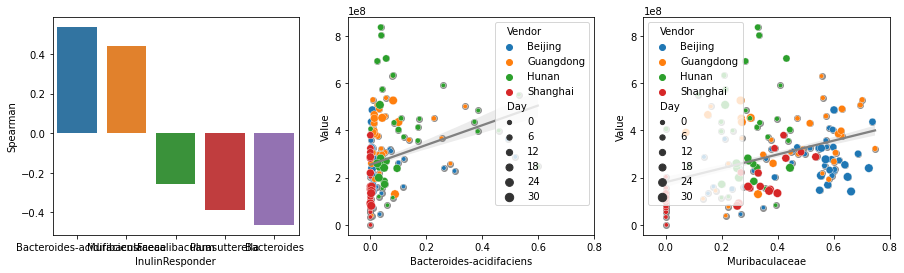

In [7]:
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(15,4))

# spearman
_ = sns.barplot(x='InulinResponder', y='Spearman', data=df_responder_qpcr_assoc, ax=ax[0], ci=68)

# Bacteroides-acidifaciens
_ = sns.regplot(x='Bacteroides-acidifaciens', y='Value', color='gray', data=df_meta, ax=ax[1], ci=68)
_ = sns.scatterplot(x='Bacteroides-acidifaciens', y='Value', hue='Vendor', size='Day', data=df_meta, ax=ax[1])
_ = ax[1].set_xlim([-0.08,0.8])

# Muribaculaceae
_ = sns.regplot(x='Muribaculaceae', y='Value', color='gray', data=df_meta, ax=ax[2], ci=68)
_ = sns.scatterplot(x='Muribaculaceae', y='Value', hue='Vendor', size='Day', data=df_meta, ax=ax[2])
_ = ax[2].set_xlim([-0.08,0.8])

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('correlation_inulin_responder_vs_qpcr.svg', format='svg')

# Test association between baseline microbiota and averaged relative abundance of inulin responder

In [3]:
lines_individual = []
lines_assoc = []

inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
all_bacteria = list(df_16S_relab.columns)
for bac in all_bacteria:
    for responder in inulin_responders:
        baseline = []
        normalized_area = []
        for mice in set(df_meta.MiceID):
            curr_df = df_meta[df_meta.MiceID==mice].sort_values(by='Day')
            vendor = list(set(curr_df['Vendor']))[0]
            baseline.append(list(curr_df[bac])[0])
            x = list(curr_df.Day)
            y = list(curr_df[responder])
            normalized_area.append(simps(y,x)/np.max(x)) # area under the curve divided by duration
            lines_individual.append([mice, 
                                     vendor, 
                                     bac,
                                     responder,
                                     baseline[-1],
                                     normalized_area[-1]
                                    ])
        
        # filtering condition: mean bacterial relative abundance in baseline >= 5%
        if np.mean(baseline) >= 0.05:
            lines_assoc.append([bac, responder, spearmanr(baseline,normalized_area)[0]])

# save spearman correlation file
df_baseline_responder_assoc = pd.DataFrame(lines_assoc, columns=['BaselineSpecies','InulinResponder','Spearman'])
df_baseline_responder_assoc.to_csv('baseline_species_vs_inulin_responder_spearman_correlation.csv')

df_baseline_responder_individual = pd.DataFrame(lines_individual, columns=['MiceID','Vendor','BaselineSpecies','InulinResponder','BaselineSpeciesRelAB','MeanResponderRelAB'])
df_baseline_responder_individual.head()

,MiceID,Vendor,BaselineSpecies,InulinResponder,BaselineSpeciesRelAB,MeanResponderRelAB
0,BI5,Beijing,A2,Bacteroides-acidifaciens,0.000000,0.046280
1,SI3,Shanghai,A2,Bacteroides-acidifaciens,0.000748,0.000386
2,GI2,Guangdong,A2,Bacteroides-acidifaciens,0.000192,0.037393
3,SI2,Shanghai,A2,Bacteroides-acidifaciens,0.000881,0.000528
4,BI1,Beijing,A2,Bacteroides-acidifaciens,0.000000,0.028126


Parabacteroides-goldsteinii Muribaculaceae SpearmanrResult(correlation=-0.9256965944272446, pvalue=3.6936283769727216e-08)
Bacteroides Bacteroides-acidifaciens SpearmanrResult(correlation=-0.7481940144478844, pvalue=0.00035556828754260204)
Desulfovibrionaceae Bacteroides SpearmanrResult(correlation=-0.5606608904099325, pvalue=0.015504235464428523)
Parabacteroides-goldsteinii Bacteroides SpearmanrResult(correlation=0.8101135190918473, pvalue=4.594554343625327e-05)
Muribaculaceae Bacteroides-acidifaciens SpearmanrResult(correlation=0.7192982456140351, pvalue=0.0007666636665897179)
Desulfovibrionaceae Muribaculaceae SpearmanrResult(correlation=0.6845638496165475, pvalue=0.0017242242213718415)


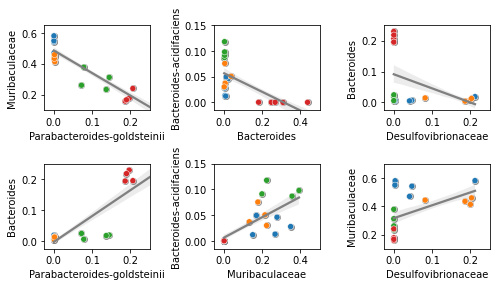

In [4]:
# plot the top3 positive or negative associations
fig, ax=plt.subplots(nrows=2, ncols=3, figsize=(7,4))
for i in [0,1]:# positive or negative association
    for j in [0,1,2]:# top 3 associations
        if i==0:
            bacteria = df_baseline_responder_assoc.sort_values('Spearman').iloc[j]['BaselineSpecies']
            responder = df_baseline_responder_assoc.sort_values('Spearman').iloc[j]['InulinResponder']
        else:
            bacteria = df_baseline_responder_assoc.sort_values('Spearman', ascending=False).iloc[j]['BaselineSpecies']
            responder = df_baseline_responder_assoc.sort_values('Spearman', ascending=False).iloc[j]['InulinResponder']
        df_tmp = df_baseline_responder_individual[(df_baseline_responder_individual.BaselineSpecies==bacteria)&(df_baseline_responder_individual.InulinResponder==responder)].sort_values('Vendor')
        _ = sns.regplot(x='BaselineSpeciesRelAB', y='MeanResponderRelAB', color='gray', data=df_tmp, ax=ax[i,j], ci=68)
        _ = sns.scatterplot(x='BaselineSpeciesRelAB', y='MeanResponderRelAB', hue='Vendor', data=df_tmp, ax=ax[i,j])
        _ = ax[i,j].legend().remove()
        _ = ax[i,j].set_xlabel(bacteria)
        _ = ax[i,j].set_ylabel(responder)
        print(bacteria, responder, spearmanr(df_tmp.BaselineSpeciesRelAB, df_tmp.MeanResponderRelAB))
        
        if i==0 and j==0:
            _ = ax[i,j].set_xlim([-0.025,0.25])
            _ = ax[i,j].set_ylim([0.1,0.65])
        if i==0 and j==1:
            _ = ax[i,j].set_xlim([-0.05,0.5])
            _ = ax[i,j].set_ylim([-0.015,0.15])
        if i==0 and j==2:
            _ = ax[i,j].set_xlim([-0.025,0.25])
            _ = ax[i,j].set_ylim([-0.025,0.25])
        if i==1 and j==0:
            _ = ax[i,j].set_xlim([-0.025,0.25])
            _ = ax[i,j].set_ylim([-0.025,0.25])
        if i==1 and j==1:
            _ = ax[i,j].set_xlim([-0.05,0.5])
            _ = ax[i,j].set_ylim([-0.015,0.15])
        if i==1 and j==2:
            _ = ax[i,j].set_xlim([-0.025,0.25])
            _ = ax[i,j].set_ylim([0.1,0.7])
        
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('correlation_baseline_vs_inulin_responder.svg', format='svg')